In [1]:
import os
import numpy as np
import art
import torchvision
from torchvision import transforms as transforms
from PIL import Image
import torch
import torchvision.models as models
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pycocotools.coco import COCO
import random
import cv2
import pycocotools.coco as coco
from mean_average_precision import MeanAveragePrecision
np.random.seed(43)

In [2]:
def load_image_from_path(img_path):
    """
    Load image from path and convert it as a np.ndarray of shape (1,width,height,3)
    """
    image = Image.open(img_path).convert('RGB')
    image_as_array = np.array(image)
    image_as_array = np.expand_dims(image_as_array, 0)
    return image_as_array

In [3]:
def make_images_array(directory, width,height):
    """
    Loading images from directory and returns them as a np.ndarray of shape (n,width,height,3)
    n - number of photos in directory
    """
    images_paths = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    #(n,width,height,3)
    images_array = np.empty([len(images_paths),width,height,3])
    
    for i, image_path in enumerate(images_paths):
        image = Image.open(directory +"/" + image_path).convert('RGB')
        image = image.resize((width,height))
        img_arr = np.array(image)
        images_array[i,:,:,:] = np.array(image)
    return images_array
   

In [4]:

def draw_image_with_boxes(image, model):
    """
    Drawing model predictions for image.
    image is a np.ndarray of shape (1,width,height,3)
    """
    predictions = model.predict(np.float32(image))
    print(predictions)
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions[0]['labels'])]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions[0]['boxes'])] # Bounding boxes
    pred_score = list(predictions[0]['scores'])
    img = np.resize(image, image.shape[1:])
    for i in range(len(boxes)):
        if pred_score[i] > 0.4:
            cv2.rectangle(img, boxes[i][0], boxes[i][1],color= (255,0,0), thickness=2) # Draw rectangle
            cv2.putText(img,pred_class[i] + ", "+ str(round(pred_score[i],2)), boxes[i][0],  cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0),thickness=2) # Write the prediction class and score     
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Loading Dataset

In [6]:
def download_choosen_categories_coco_images(annFilePath,lis_of_imgs_categories, num_of_imgs):
    catIds = coco.getCatIds(catNms=lis_of_imgs_categories);
    imgIds=[]
    for i in catIds:
        imgIds.append(coco.getImgIds(catIds=i))
    imgIds = [item for sublist in imgIds for item in sublist]
    if len(imgids)<num_of_imgs:
        num_of_imgs = len(imgids)
    np.random.shuffle(imgIds)
    randImgIds = imgIds[:num_of_imgs]
    coco.download(tarDir = "photos", imgIds = randImgIds)

In [7]:
images_array = make_images_array("photos", 300, 300)
images_array = images_array
print(images_array.shape)

(17, 300, 300, 3)


# Creating a model

In [8]:

art_model = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255], device_type = 'gpu')



[{'boxes': array([[563.2966 , 345.40332, 880.6374 , 596.1336 ],
       [187.74022, 220.00258, 500.19757, 578.8625 ],
       [464.5193 , 448.03387, 589.05597, 567.2614 ]], dtype=float32), 'labels': array([22, 22, 22], dtype=int64), 'scores': array([0.999671  , 0.99941766, 0.9988954 ], dtype=float32)}]


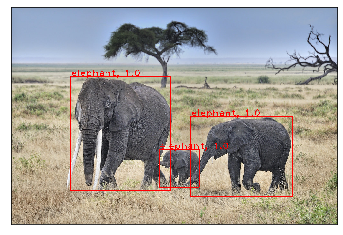

In [22]:
image = load_image_from_path('elephant.jpg')
draw_image_with_boxes(image, art_model)

# DPatch

In [9]:
attackDPatch = art.attacks.evasion.DPatch(art_model, batch_size = 1, max_iter = 500)

Creating a dpatch

In [10]:
mask = (np.zeros(images_array.shape[1:-1]) == 0)
mask = np.expand_dims(mask, 0)

In [11]:
#adv_dpatch = attackDPatch.generate(np.float32(images_array[:,:,:,:]), mask = mask)

In [12]:
#patch_img = Image.fromarray((adv_dpatch).astype(np.uint8))
#patch_img.save("DPatch.jpg")
#plt.imshow(patch_img)
#plt.show()

Applying path on images

In [13]:
adv_dpatch = load_image_from_path("DPatch.jpg")
adv_dpatch.resize((40,40,3))
torch.cuda.empty_cache()

In [12]:
dpath_images = attackDPatch.apply_patch(np.float32(images_array), patch_external=adv_dpatch)
img =  Image.fromarray((dpath_images[0,:,:,:]).astype(np.uint8))
img.save("robust_zebra.jpg")
Dpathed_img =  load_image_from_path('robust_zebra.jpg')
Dpathed_img.shape

(1, 300, 300, 3)

[{'boxes': array([[ 56.340004 ,  75.10768  , 245.42294  , 249.65137  ],
       [  9.133921 , 102.14635  ,  46.072826 , 130.63408  ],
       [  1.2602477,  39.42827  ,  45.2912   ,  82.52272  ],
       [  1.8138528,   0.       ,  45.523964 ,  83.77724  ]],
      dtype=float32), 'labels': array([24, 24, 22,  1], dtype=int64), 'scores': array([0.9997681 , 0.9875337 , 0.06679031, 0.05100019], dtype=float32)}]


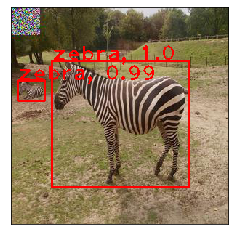

In [16]:
draw_image_with_boxes(Dpathed_img,art_model)

# RobustDPatch

In [17]:
attackRobustDPatch = art.attacks.evasion.RobustDPatch(art_model, batch_size = 1, max_iter = 500)

In [18]:
#adv_robust_patch = attackRobustDPatch.generate(np.float32(images_array[0:1,:,:,:]))

In [19]:
#patch_img = Image.fromarray((adv_robust_patch).astype(np.uint8))
#patch_img.save("RobustDPatch.jpg")
#plt.imshow(patch_img)
#plt.show()

In [13]:
#adv_robust_patch = Image.open("RobustDPatch.jpg").convert('RGB')
#plt.imshow(adv_robust_patch)
#plt.show()
adv_robust_patch = load_image_from_path("RobustDPatch.jpg")
adv_robust_patch.resize((40,40,3))

In [16]:
robust_dpath_images = attackRobustDPatch.apply_patch(np.float32(images_array), patch_external=adv_robust_patch)
img =  Image.fromarray((robust_dpath_images[0,:,:,:]).astype(np.uint8))
img.save("robustDpath_zebra.jpg")
robust_dpath_image =  load_image_from_path('robustDpath_zebra.jpg')
robust_dpath_image.shape

(1, 300, 300, 3)

[{'boxes': array([[ 56.348362 ,  75.1115   , 245.42418  , 249.65076  ],
       [  9.133829 , 102.14638  ,  46.07373  , 130.63414  ],
       [  0.6001668,  38.794937 ,  47.82439  ,  84.37804  ],
       [  1.0362997,  37.173904 ,  47.143177 ,  84.41039  ]],
      dtype=float32), 'labels': array([24, 24, 22, 19], dtype=int64), 'scores': array([0.9997681 , 0.9875146 , 0.32244927, 0.05181618], dtype=float32)}]


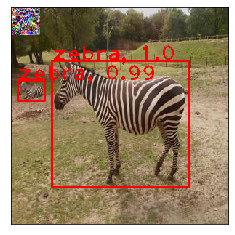

In [29]:
draw_image_with_boxes(robust_dpath_image,art_model)

In [9]:
img =  Image.fromarray((images_array[0,:,:,:]).astype(np.uint8))
img.save("normal_zebra.jpg")
normal_image =  load_image_from_path('normal_zebra.jpg')
normal_image.shape

(1, 300, 300, 3)

# Evaluating model performance after attacks


In [20]:
normal_predictions = art_model.predict(np.float32(normal_image))
dpatch_predictions = art_model.predict(np.float32(Dpathed_img))
robust_dpatch_predictions = art_model.predict(np.float32(robust_dpath_image))

Converting predictions to MeanAveragePrecision format

In [28]:
def patched_to_MAP(preds):
    filter_normal = preds[0]["scores"] > 0.1
    filter_scores = preds[0]["scores"][filter_normal]
    stack = np.stack((preds[0]["labels"], preds[0]["scores"]), axis=1)
    gt = np.concatenate((preds[0]["boxes"], stack), axis=1)
    gt = gt[filter_normal]
    return gt
    
def normal_to_MAP(preds):
    normal = patched_to_MAP(preds)
    normal = normal[:,0:5]
    N = normal.shape[0]
    normal = np.concatenate((normal, np.zeros((N,2))), axis = 1)
    return normal

In [30]:
normalmAP = normal_to_MAP(normal_predictions)
dpatchmAP = patched_to_MAP(dpatch_predictions)
robust_dpatchmAP = patched_to_MAP(robust_dpatch_predictions)

DPatch mAP:

In [32]:
dpatchmAP.shape

(2, 6)

In [34]:
# create metric_fn
metric_fn = MeanAveragePrecision(num_classes=len(list(set(COCO_INSTANCE_CATEGORY_NAMES)))-1)

metric_fn.add(dpatchmAP, normalmAP)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

Robust DPatch mAP:

In [35]:
# create metric_fn
metric_fn = MeanAveragePrecision(num_classes=len(list(set(COCO_INSTANCE_CATEGORY_NAMES)))-1)

metric_fn.add(robust_dpatchmAP, normalmAP)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

# Defences

In [36]:
defence_gausian = art.defences.preprocessor.GaussianAugmentation()
defence = art.defences.preprocessor.FeatureSqueezing(clip_values=[0,255])

In [37]:
art_model_defence = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255],preprocessing_defences= [defence] )

[{'boxes': array([[ 56.348362 ,  75.1115   , 245.42418  , 249.65076  ],
       [  9.133829 , 102.14638  ,  46.07373  , 130.63414  ],
       [  0.6001668,  38.794937 ,  47.82439  ,  84.37804  ],
       [  1.0362997,  37.173904 ,  47.143177 ,  84.41039  ]],
      dtype=float32), 'labels': array([24, 24, 22, 19], dtype=int64), 'scores': array([0.9997681 , 0.9875146 , 0.32244927, 0.05181618], dtype=float32)}]


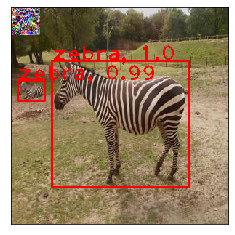

In [40]:
#torch.cuda.empty_cache()

draw_image_with_boxes(robust_dpath_image,art_model_defence )

# Evaluating model performance with defences

To Do: improve pathed, and repair make_images_array and also Evaluate model performance with defences